# CAFA 5

This notebook is my solution for [CAFA 5 competition](https://www.kaggle.com/competitions/cafa-5-protein-function-prediction). Cafa 5 goal is to predict functions of a set of proteins . Method presented here incorporates such solutions as:
- Use of protein sequence embeddings, generated by ESM2.
- Combining cross entropy loss with triplet loss, which works well for labeling problems with many target classes. It was inspired by [this paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1010793).
- Taking advantage of graph structure of Gene Ontologies, which allows the use of Graph Neural Netowrks. This method was proposed in [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8808544/pdf/lqac004.pdf).
- CV folds, that groups similar proteins together. Motivation and folds can be found [here](https://www.kaggle.com/code/alexandervc/cafa5-23-groups-and-folds-diamond-igraph).

# Setup

In [1]:
!pip install obonet
!pip install pyvis
!pip install biopython
!pip install torch
!pip install lightning
!pip install torchmetrics
!pip install torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import json
import os
import zipfile
import shutil

import obonet
import networkx
from pyvis.network import Network
from Bio import SeqIO

import networkx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import progressbar

import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy

import torch_geometric.nn as geom_nn

from tqdm import tqdm
from google.colab import drive
from datetime import datetime
from sklearn.metrics import roc_auc_score





In [3]:

with open('kaggle.json') as f:
  data = json.load(f)
  os.environ['KAGGLE_USERNAME'] = data['username']
  os.environ['KAGGLE_KEY'] = data['key']

In [4]:
!kaggle competitions download -c cafa-5-protein-function-prediction
!kaggle datasets download -d andreylalaley/23468234
!kaggle kernels output johanprogramista2/diamond -p ./diamond
!kaggle kernels output alexandervc/cafa5-23-groups-and-folds-diamond-igraph -p ./folds


 98% 113M/115M [00:09<00:00, 19.5MB/s]
100% 115M/115M [00:09<00:00, 12.8MB/s]
100% 1.52G/1.52G [01:36<00:00, 21.6MB/s]
100% 1.52G/1.52G [01:36<00:00, 17.0MB/s]
Output file downloaded to ./diamond/diamond
Output file downloaded to ./diamond/matches.tsv
Output file downloaded to ./diamond/test_diamond_gos.tsv
Output file downloaded to ./diamond/train_db.dmnd
Output file downloaded to ./diamond/train_diamond_gos.tsv
Output file downloaded to ./diamond/train_matches.tsv
Kernel log downloaded to ./diamond/diamond.log 
Output file downloaded to ./folds/Y_pred_submit|Ridge1|cv_folds_10.npy
Output file downloaded to ./folds/Y_pred_submit|Ridge1|cv_folds_15.npy
Output file downloaded to ./folds/Y_pred_submit|Ridge1|cv_folds_5.npy
Output file downloaded to ./folds/df_folds_Nsims5_evalue1e-06.csv
Output file downloaded to ./folds/df_groups_Nsims5_evalue1e-06.csv
Kernel log downloaded to ./folds/cafa5-23-groups-and-folds-diamond-igraph.log 


In [5]:
class Conf():
  cafa_zip = 'cafa-5-protein-function-prediction.zip'
  cafa_data = 'data/proteins'
  train_go_data = 'data/proteins/Train/go-basic.obo'
  train_seq_fasta = 'data/proteins/Train/train_sequences.fasta'
  train_terms = 'data/proteins/Train/train_terms.tsv'

  embd_zip = '23468234.zip'
  embd_data = 'data/embeddings'
  train_embds = 'data/embeddings/train_embeds_esm2_t33_650M_UR50D.npy'
  train_embd_ids = 'data/embeddings/train_ids_esm2_t33_650M_UR50D.npy'
  test_embds = 'data/embeddings/test_embeds_esm2_t33_650M_UR50D.npy'
  test_embd_ids = 'data/embeddings/test_ids_esm2_t33_650M_UR50D.npy'

  cv_folds = "folds/df_folds_Nsims5_evalue1e-06.csv"

  labels_dir = 'data/labels'
  labels_name = 'label'
  num_labels = 500



In [6]:
with (zipfile.ZipFile(Conf.cafa_zip, 'r') as cafa_zip,
     zipfile.ZipFile(Conf.embd_zip, 'r') as embd_zip):
    cafa_zip.extractall(Conf.cafa_data)
    embd_zip.extractall(Conf.embd_data)


# Embedings

In [7]:

train_terms = pd.read_csv(Conf.train_terms,sep="\t")

esm2_embds = np.load(Conf.train_embds)
train_ids = np.load(Conf.train_embd_ids)
test_ids = np.load(Conf.test_embd_ids)
dest = Conf.labels_dir + "/" + Conf.labels_name + str(Conf.num_labels) + ".pkl"

top_terms = train_terms.groupby(['term'])['term'].count().sort_values(ascending=False)[:Conf.num_labels]
filtered_train_terms = train_terms[train_terms['term'].isin(list(top_terms.keys()))]
terms_to_ids = {term: i for i, term in enumerate(list(top_terms.keys()))}
proteins_to_id = {prot_id: i for i, prot_id in enumerate(train_ids)}
test_proteins_to_id = {prot_id: i for i, prot_id in enumerate(test_ids)}


In [8]:
# CREATE LABELS

labels = np.zeros((len(train_ids), Conf.num_labels))

for protein_id, term in zip(filtered_train_terms['EntryID'], filtered_train_terms['term']):
  if term not in terms_to_ids: continue
  term_pos = terms_to_ids[term]
  prot_pos = proteins_to_id[protein_id]
  labels[prot_pos, term_pos] = 1

labels_list = []
for l in range(labels.shape[0]):
    labels_list.append(labels[l, :])

labels_df = pd.DataFrame(data={"EntryID": train_ids, "labels_vect": labels_list})
os.makedirs(Conf.labels_dir, exist_ok=True)
labels_df.to_pickle(dest)



In [9]:
# GENERATE DIAMOND RESULTS

train_df = pd.read_csv("diamond/train_diamond_gos.tsv",sep="\t")
test_df = pd.read_csv("diamond/test_diamond_gos.tsv",sep="\t")
test_df.columns=["qseqid", "terms", "ntargets"]
top_terms_set = set(top_terms.keys())

filtered_train_df = train_df[train_df['terms'].isin(top_terms_set)]
filtered_test_df = test_df[test_df['terms'].isin(top_terms_set)]

diamond_scores_train = np.zeros((len(train_ids), Conf.num_labels))
diamond_scores_test = np.zeros((len(test_ids), Conf.num_labels))

for prot, term, ntargets in zip(filtered_train_df['qseqid'],
                                filtered_train_df['terms'],
                                filtered_train_df['ntargets']):
  prot_id = proteins_to_id[prot]
  term_id = terms_to_ids[term]

  diamond_scores_train[prot_id, term_id] = ntargets

for prot, term, ntargets in zip(filtered_test_df['qseqid'],
                                filtered_test_df['terms'],
                                filtered_test_df['ntargets']):
  prot_id = test_proteins_to_id[prot]
  term_id = terms_to_ids[term]

  diamond_scores_test[prot_id, term_id] = ntargets

train_list = []
for l in range(diamond_scores_train.shape[0]):
  train_list.append(diamond_scores_train[l, :])

test_list = []
for l in range(diamond_scores_test.shape[0]):
  test_list.append(diamond_scores_test[l, :])

train_diamond_df = pd.DataFrame(data={"EntryID": train_ids, "diamond": train_list})
test_diamond_df = pd.DataFrame(data={"EntryID": test_ids, "diamond": test_list})

os.makedirs("data/diamond_scores", exist_ok=True)
train_diamond_df.to_pickle("data/diamond_scores/train.pkl")
test_diamond_df.to_pickle("data/diamond_scores/test.pkl")

In [10]:
def create_edges(terms_to_ids, radius=1):
  graph = obonet.read_obo(Conf.train_go_data)
  nodes = set(terms_to_ids.keys())
  edges = []
  for node in nodes:
    ng_graph = networkx.ego_graph(graph, node, radius=radius)
    important_nodes = [n for n in ng_graph.nodes if n in nodes]
    edges += [(terms_to_ids[node], terms_to_ids[connected_node]) for connected_node in important_nodes]
  edges_t = torch.tensor(edges, dtype=torch.long)
  edges_t = edges_t.t().contiguous()
  return edges_t

edges_t = create_edges(terms_to_ids)


In [11]:
folds = pd.read_csv(Conf.cv_folds,sep=",")
fold_groups = np.asarray(folds["cv_folds_5"])

# Dataset

In [12]:

class ProteinSequenceDataset(Dataset):

    def __init__(self, datatype):
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype

        if datatype == "train":
          embeds = np.load(Conf.train_embds)
          ids = np.load(Conf.train_embd_ids)
          df_diamond = pd.read_pickle("data/diamond_scores/train.pkl")
          # t5 = np.load(Conf.train_t5)
          # t5_ids = np.load(Conf.train_t5_ids)
        else:
          embeds = np.load(Conf.test_embds)
          ids = np.load(Conf.test_embd_ids)
          df_diamond = pd.read_pickle("data/diamond_scores/test.pkl")

        embeds_list = []
        # t5_list = []

        for l in range(embeds.shape[0]):
          embeds_list.append(embeds[l,:])
          # t5_list.append(t5[l,:])

        # self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list, "t5": t5_list})
        self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})

        if datatype=="train":
          df_labels = pd.read_pickle(Conf.labels_dir + "/" + Conf.labels_name + str(Conf.num_labels) + ".pkl")
          self.df = self.df.merge(df_labels, on="EntryID")
        self.df = self.df.merge(df_diamond, on="EntryID")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        esm2 = torch.tensor(row["embed"] , dtype = torch.float32)
        embed = esm2
        diamond_score = torch.tensor(row["diamond"] , dtype = torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype = torch.float32)
            return embed, diamond_score, targets
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, diamond_score, id


## Triplet Loss

In [13]:
class HardTripletLoss:
  def __init__(self, cf=0.6, margin=0.1) -> None:
    self.cf = cf
    self.margin = margin

  def __call__(self, preds, labels, device="cuda"):
    ns = torch.mm(labels, labels.t())
    diag = torch.diagonal(ns, 0)
    na = diag.repeat(ns.shape[0], 1)
    nb = na.t()
    pre = ns / na
    rec = ns / nb
    functional_similarity_matrix = 2 * pre * rec / (pre + rec)
    positive_matrix = (functional_similarity_matrix >= self.cf).fill_diagonal_(False)
    negative_matrix = (functional_similarity_matrix < self.cf).fill_diagonal_(False)

    distances = torch.cdist(preds, preds)
    pos = torch.where(positive_matrix, distances, 0).max(-1).values
    neg = torch.where(negative_matrix, distances, torch.inf).min(-1).values

    neg[neg == float("Inf")] = 0 # safeguard for rare cases, when there is no negative sample


    loss = torch.maximum(pos + self.margin - neg, torch.tensor([0]).to(device))
    return torch.sum(loss)


In [14]:
def get_triplet_prediction(embeddings, database, k=100, device="cuda"):
  all_embeddings, labels = database

  distances = torch.cdist(embeddings, all_embeddings)
  sorted_distances, indices = torch.sort(distances, dim=1)
  k_indices = indices[:, :k]
  ranks = torch.arange(1, k + 1).repeat(k_indices.shape[0], 1).to(device)

  wk = 1 - (ranks - 1) / k

  # wk = wk.unsqueeze(dim=2)

  wk = wk / torch.sum(wk, dim=1, keepdim=True)
  wk = wk.unsqueeze(dim=2)

  weighted_labels = labels[k_indices] * wk
  final_prediction = torch.sum(weighted_labels, dim=1)

  return final_prediction


# Model

In [15]:
gnn_layer_by_name = {"GCN": geom_nn.GCNConv, "GAT": geom_nn.GATConv,
                     "GraphConv": geom_nn.GraphConv}

In [16]:
class ReshapeLayer(torch.nn.Module):
  def __init__(
      self,
      out_shape
  ):
    super(ReshapeLayer, self).__init__()
    self.out_shape = out_shape

  def forward(self, x):
    x = x.view(*self.out_shape)
    return x

In [17]:
class GNNModel(nn.Module):
    def __init__(
        self,
        c_in,
        c_hidden,
        c_out,
        num_layers=4,
        layer_name="GAT",
        dp_rate=0,
        nodes=1000,
        batch_size=64,
        **kwargs,
    ):
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]
        self.N = nodes
        self.BS = batch_size

        layers = []
        in_channels = c_in
        out_channels = c_hidden
        for l_idx in range(num_layers - 1):
            layers += [
                ReshapeLayer((-1, in_channels)),
                gnn_layer(in_channels=in_channels, out_channels=out_channels, improved=True),
                ReshapeLayer((-1, nodes, out_channels)),
                nn.BatchNorm1d(self.N),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate),
            ]
            in_channels = c_hidden
        layers += [ReshapeLayer((-1, in_channels)),
                   gnn_layer(in_channels=in_channels, out_channels=c_out),
                   ReshapeLayer((-1, nodes, c_out))]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        for layer in self.layers:
            if isinstance(layer, geom_nn.MessagePassing):
                # x = x.view(self.BS * self.N, -1)
                x = layer(x, edge_index)
                # x = x.view(self.BS, self.N, -1)
            else:
                x = layer(x)
        return x

In [18]:
class SimpleDenseNetwork(torch.nn.Module):
  def __init__(
      self,
      hidden_sizes,
      output_size,
      dp_rate=0.5
  ):
        super(SimpleDenseNetwork, self).__init__()
        # self.embedding_layer1 = EmbeddingFCN(emb1_size, 512)
        # self.embedding_layer2 = EmbeddingFCN(emb2_size, 512)
        layers = []
        for in_size, out_size in zip(hidden_sizes[:-1], hidden_sizes[1:]):
          layers += [
              torch.nn.Linear(in_size, out_size),
              nn.BatchNorm1d(out_size),
              torch.nn.ReLU(),
              nn.Dropout(dp_rate)
          ]
        layers += [torch.nn.Linear(hidden_sizes[-1], output_size),
                  nn.BatchNorm1d(output_size),
                  torch.nn.ReLU(),
                  nn.Dropout(dp_rate)]
        self.layers = nn.ModuleList(layers)

  def forward(self, x):
    # x, _ = x[0], x[1]
    # e1 = self.embedding_layer1(e1)
    # e2 = self.embedding_layer2(e2)
    # x = torch.cat((e1, e2), dim=1)
    for layer in self.layers:
      x = layer(x)
    return x

In [19]:
class Cafa5Model(torch.nn.Module):
  def __init__(
      self,
      input_size,
      output_size,
      dense_nets=2,
      dense_sizes=(512, 1024),
      gnn_hidden=16,
      gnn_layers=3,
      dp_rate=0.5,
      output_embedding_size=512
  ):
    super(Cafa5Model, self).__init__()

    hidden_sizes = [input_size, *dense_sizes]
    dense_layers = []
    for _ in range(dense_nets):
      dense_layers += [SimpleDenseNetwork(hidden_sizes=hidden_sizes,
                                          output_size=output_size)]
    self.dense_nets = nn.ModuleList(dense_layers)
    c_in = dense_nets
    c_out = 1
    c_hidden = gnn_hidden
    self.gnn = GNNModel(c_in=c_in, c_hidden=c_hidden, c_out=c_out, nodes=output_size, num_layers=gnn_layers)
    output_layers = [nn.BatchNorm1d(output_size),
                     torch.nn.ReLU(),
                     torch.nn.Linear(output_size, output_size)]
    self.output_layers = nn.ModuleList(output_layers)

    output_embedding_layers = [
        nn.BatchNorm1d(output_size),
        torch.nn.ReLU(),
        torch.nn.Linear(output_size, output_embedding_size)]
    self.output_embedding_layers = nn.ModuleList(output_embedding_layers)

  def forward(self, x, diamond_scores, edges):
    xs = [dense_net(x) for dense_net in self.dense_nets]
    x = torch.stack(xs, dim=2)
    inter_x = torch.sum(x, dim=2)
    # diamond_scores = torch.unsqueeze(diamond_scores, dim=2)
    # x = torch.cat((x, diamond_scores), dim=2)
    x = self.gnn(x, edges)
    x = torch.squeeze(x, dim=2)
    x = x + inter_x
    x2 = torch.clone(x)

    for layer in self.output_layers:
      x = layer(x)

    for layer in self.output_embedding_layers:
      x2 = layer(x2)
    return x, x2

In [20]:
class MLConf():
  batch_size = 256
  device = 'cuda'
  n_epochs = 3
  lr = 1e-3
  triple_weight = 0.15


In [21]:
from tqdm import tqdm
embd1_size = esm2_embds.shape[1]
# embd2_size = t5_embds.shape[1]


def train_model(fold, train_size=0.9):
  train_dataset = ProteinSequenceDataset(datatype="train")

  # train_set, val_set = random_split(train_dataset,
  #                                   lengths = [int(len(train_dataset)*train_size),
  #                                              len(train_dataset)-int(len(train_dataset)*train_size)],
  #                                   generator=torch.Generator().manual_seed(422137))
  test_indices = np.argwhere(fold_groups!=fold).flatten()
  val_indices = np.argwhere(fold_groups==fold).flatten()
  train_set = torch.utils.data.dataset.Subset(train_dataset, test_indices)
  val_set = torch.utils.data.dataset.Subset(train_dataset, val_indices)

  train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=MLConf.batch_size, shuffle=True)
  val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=MLConf.batch_size, shuffle=True)

  # database_length = len(train_dataloader) * MLConf.batch_size

  model = Cafa5Model(input_size = embd1_size,
                     output_size=Conf.num_labels,
                     dense_nets=1,
                     dense_sizes=(512, 512, 700),
                     gnn_hidden=16,
                     gnn_layers=5).to(MLConf.device)
  edges_cuda = edges_t.to(MLConf.device)

  optimizer = torch.optim.Adam(model.parameters(), lr = MLConf.lr)
  scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=2)
  cross_entropy = torch.nn.CrossEntropyLoss()
  triple_loss = HardTripletLoss(cf=0.7, margin=0.1)
  f1_score = MultilabelF1Score(num_labels=Conf.num_labels).to(MLConf.device)
  n_epochs = MLConf.n_epochs

  print("BEGIN TRAINING...")
  train_loss_history=[]
  val_loss_history=[]

  train_f1score_history=[]
  val_f1score_history=[]

  for epoch in range(n_epochs):
    print("EPOCH ", epoch+1)
    ## TRAIN PHASE :
    model.train()

    losses = []
    scores = []
    for embed, diamond_scores, targets in tqdm(train_dataloader):
        embed, diamond_scores, targets = (embed.to(MLConf.device),
                                          diamond_scores.to(MLConf.device),
                                          targets.to(MLConf.device))
        optimizer.zero_grad()
        preds, pred_embds = model(embed, diamond_scores, edges_cuda)
        loss = (
              cross_entropy(preds, targets) * (1 - MLConf.triple_weight) +
              triple_loss(pred_embds, targets, device=MLConf.device) * MLConf.triple_weight
        )
        score = f1_score(preds, targets)
        losses.append(loss.item())
        scores.append(score.item())
        loss.backward()
        optimizer.step()
    avg_loss = np.mean(losses)
    avg_score = np.mean(scores)
    print("Running Average TRAIN Loss : ", avg_loss)
    print("Running Average TRAIN F1-Score : ", avg_score)
    train_loss_history.append(avg_loss)
    train_f1score_history.append(avg_score)

  ## UPDATE EMBEDDING DATABASE

    final_embeddings = []
    corresponding_labels = []

    model.eval()

    with torch.no_grad():
      for embed, diamond_scores, targets in train_dataloader:
        embed, diamond_scores, targets = (embed.to(MLConf.device),
                                          diamond_scores.to(MLConf.device),
                                          targets.to(MLConf.device))
        preds, embd_preds = model(embed, diamond_scores, edges_cuda)
        final_embeddings += embd_preds
        corresponding_labels += targets

      final_embeddings = torch.stack(final_embeddings)
      corresponding_labels = torch.stack(corresponding_labels)
      database = final_embeddings, corresponding_labels

    ## VALIDATION PHASE :
      losses = []
      scores = []

      for i,(embed, diamond_scores, targets) in enumerate(val_dataloader):
          embed, diamond_scores, targets = (embed.to(MLConf.device),
                                            diamond_scores.to(MLConf.device),
                                            targets.to(MLConf.device))
          preds, pred_embds = model(embed, diamond_scores, edges_cuda)
          loss = (
              cross_entropy(preds, targets) * (1 - MLConf.triple_weight) +
              triple_loss(pred_embds, targets, device=MLConf.device) * MLConf.triple_weight
          )
          final_pred = (
              get_triplet_prediction(pred_embds, database, device=MLConf.device) * MLConf.triple_weight +
              preds * (1 - MLConf.triple_weight)
          )
          final_pred = torch.nn.functional.sigmoid(final_pred)
          score = f1_score(final_pred, targets)
          losses.append(loss.item())
          scores.append(score.item())
      avg_loss = np.mean(losses)
      avg_score = np.mean(scores)
      print("Running Average VAL Loss : ", avg_loss)
      print("Running Average VAL F1-Score : ", avg_score)
      val_loss_history.append(avg_loss)
      val_f1score_history.append(avg_score)

    scheduler.step(avg_loss)
    print("\n")

  print("TRAINING FINISHED")
  print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
  print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])

  losses_history = {"train" : train_loss_history, "val" : val_loss_history}
  scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}

  return model, losses_history, scores_history


In [22]:
models, lossess, scoress = [],[],[]
for fold in range(5):
  model, losses, scores = train_model(fold)
  models.append(model)
  lossess.append(losses)
  scoress.append(scores)



BEGIN TRAINING...
EPOCH  1


100%|██████████| 445/445 [00:31<00:00, 14.01it/s]


Running Average TRAIN Loss :  149.47988061797753
Running Average TRAIN F1-Score :  0.09329701806889491
Running Average VAL Loss :  178.07396173477173
Running Average VAL F1-Score :  0.11621640842141849


EPOCH  2


100%|██████████| 445/445 [00:27<00:00, 16.47it/s]


Running Average TRAIN Loss :  129.4774446465996
Running Average TRAIN F1-Score :  0.12375372683399179
Running Average VAL Loss :  150.65901613235474
Running Average VAL F1-Score :  0.13996554498693772


EPOCH  3


100%|██████████| 445/445 [00:26<00:00, 16.65it/s]


Running Average TRAIN Loss :  121.14344002370085
Running Average TRAIN F1-Score :  0.14304103695609596
Running Average VAL Loss :  140.25757816859655
Running Average VAL F1-Score :  0.15592603172574723


TRAINING FINISHED
FINAL TRAINING SCORE :  0.14304103695609596
FINAL VALIDATION SCORE :  0.15592603172574723
BEGIN TRAINING...
EPOCH  1


100%|██████████| 445/445 [00:26<00:00, 16.71it/s]


Running Average TRAIN Loss :  151.000436469946
Running Average TRAIN F1-Score :  0.08916080283482423
Running Average VAL Loss :  167.8718022618975
Running Average VAL F1-Score :  0.11378604492970876


EPOCH  2


100%|██████████| 445/445 [00:26<00:00, 16.75it/s]


Running Average TRAIN Loss :  131.60850154576676
Running Average TRAIN F1-Score :  0.11790167739552058
Running Average VAL Loss :  142.87400204794747
Running Average VAL F1-Score :  0.1392961234253432


EPOCH  3


100%|██████████| 445/445 [00:26<00:00, 16.73it/s]


Running Average TRAIN Loss :  123.45920583317789
Running Average TRAIN F1-Score :  0.1356336897511161
Running Average VAL Loss :  129.64945111955916
Running Average VAL F1-Score :  0.15595729037054948


TRAINING FINISHED
FINAL TRAINING SCORE :  0.1356336897511161
FINAL VALIDATION SCORE :  0.15595729037054948
BEGIN TRAINING...
EPOCH  1


100%|██████████| 445/445 [00:26<00:00, 16.60it/s]


Running Average TRAIN Loss :  150.53191070556642
Running Average TRAIN F1-Score :  0.09212738617919804
Running Average VAL Loss :  168.76327882494246
Running Average VAL F1-Score :  0.10671042438064303


EPOCH  2


100%|██████████| 445/445 [00:27<00:00, 16.37it/s]


Running Average TRAIN Loss :  130.99804039430083
Running Average TRAIN F1-Score :  0.12498334150635794
Running Average VAL Loss :  145.2600372178214
Running Average VAL F1-Score :  0.13098762796393462


EPOCH  3


100%|██████████| 445/445 [00:26<00:00, 16.52it/s]


Running Average TRAIN Loss :  122.78343276120303
Running Average TRAIN F1-Score :  0.1429644902770439
Running Average VAL Loss :  132.53323486873083
Running Average VAL F1-Score :  0.14607185451313853


TRAINING FINISHED
FINAL TRAINING SCORE :  0.1429644902770439
FINAL VALIDATION SCORE :  0.14607185451313853
BEGIN TRAINING...
EPOCH  1


100%|██████████| 445/445 [00:26<00:00, 16.78it/s]


Running Average TRAIN Loss :  152.38327568139923
Running Average TRAIN F1-Score :  0.09545331892002834
Running Average VAL Loss :  166.61782176154
Running Average VAL F1-Score :  0.11284559925219842


EPOCH  2


100%|██████████| 445/445 [00:26<00:00, 16.62it/s]


Running Average TRAIN Loss :  131.65232682817438
Running Average TRAIN F1-Score :  0.1298845172598121
Running Average VAL Loss :  138.2237125805446
Running Average VAL F1-Score :  0.13754009062956488


EPOCH  3


100%|██████████| 445/445 [00:26<00:00, 16.75it/s]


Running Average TRAIN Loss :  123.42987168558528
Running Average TRAIN F1-Score :  0.14952442448460654
Running Average VAL Loss :  128.1698545728411
Running Average VAL F1-Score :  0.15113013171191728


TRAINING FINISHED
FINAL TRAINING SCORE :  0.14952442448460654
FINAL VALIDATION SCORE :  0.15113013171191728
BEGIN TRAINING...
EPOCH  1


100%|██████████| 445/445 [00:26<00:00, 16.88it/s]


Running Average TRAIN Loss :  151.95656981736087
Running Average TRAIN F1-Score :  0.09354132650775857
Running Average VAL Loss :  171.13254840033395
Running Average VAL F1-Score :  0.11866570091141122


EPOCH  2


100%|██████████| 445/445 [00:26<00:00, 17.00it/s]


Running Average TRAIN Loss :  131.51204499662592
Running Average TRAIN F1-Score :  0.12711301253417903
Running Average VAL Loss :  143.50747108459473
Running Average VAL F1-Score :  0.1343680619528251


EPOCH  3


100%|██████████| 445/445 [00:26<00:00, 16.94it/s]


Running Average TRAIN Loss :  123.5628314586168
Running Average TRAIN F1-Score :  0.14681450699487428
Running Average VAL Loss :  130.12953894478935
Running Average VAL F1-Score :  0.14766506291925907


TRAINING FINISHED
FINAL TRAINING SCORE :  0.14681450699487428
FINAL VALIDATION SCORE :  0.14766506291925907


In [24]:
model, losses, scores = models[0], lossess[0], scoress[0]

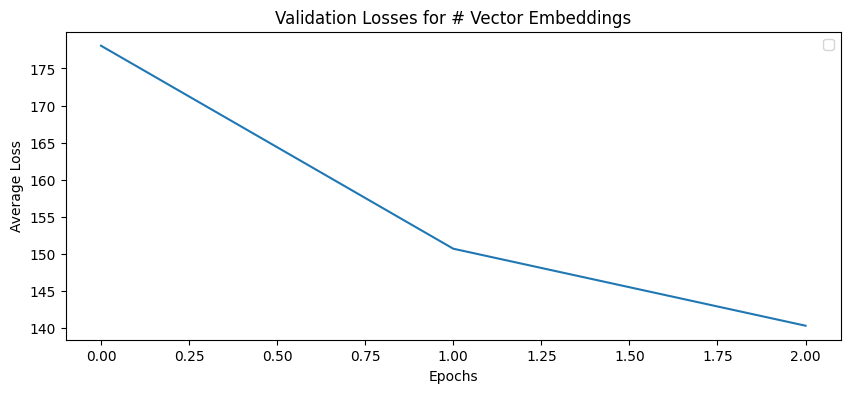

In [25]:
plt.figure(figsize = (10, 4))
plt.plot(losses["val"])
plt.title("Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))

plt.plot(scores["val"])
plt.title("Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
now = datetime.now()
date_time = now.strftime("%m-%d-%Y %H:%M:%S")

os.makedirs("model", exist_ok=True)
model_path = f"model/params{date_time}"
torch.save(model.state_dict(), model_path)

shutil.make_archive("model", 'zip', "model")

'/content/model.zip'

In [ ]:
!cp model.zip '/content/gdrive/My Drive/kaggle/'


## Predictions

In [ ]:
os.makedirs("model", exist_ok=True)

with zipfile.ZipFile("model.zip", 'r') as model_zip:
    model_zip.extractall("model")

In [ ]:
model_path = "/content/model/params08-07-2023 11:33:08"

In [ ]:
# LOAD MODEL

eval_model = Cafa5Model(input_size = embd1_size,
                    output_size=Conf.num_labels,
                    dense_nets=1,
                    dense_sizes=(512, 700),
                    gnn_hidden=8,
                    gnn_layers=4).to(MLConf.device)

eval_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
# CREATE DATABASE OF PROTEIN EMBEDDINGS FOR TRIPLET PREDICTIONS

train_dataset = ProteinSequenceDataset(datatype="train")
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=MLConf.batch_size, shuffle=False)

final_embeddings = []
corresponding_labels = []

edges_cuda = edges_t.to(MLConf.device)
eval_model = eval_model.to(MLConf.device)
eval_model.eval()

with torch.no_grad():
  for embed, diamond_scores, targets in dataloader:
    embed, diamond_scores, targets = (embed.to(MLConf.device),
                                      diamond_scores.to(MLConf.device),
                                      targets.to(MLConf.device))
    preds, embd_preds = eval_model(embed, diamond_scores, edges_cuda)
    final_embeddings += embd_preds
    corresponding_labels += targets

  final_embeddings = torch.stack(final_embeddings).to(MLConf.device)
  corresponding_labels = torch.stack(corresponding_labels).to(MLConf.device)
  database = final_embeddings, corresponding_labels

In [ ]:
def predict(model):

    test_dataset = ProteinSequenceDataset(datatype="test")
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

    edges_cuda = edges_t.to(MLConf.device)
    model.eval()

    labels = pd.read_csv(Conf.train_terms, sep = "\t")
    top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
    labels_names = top_terms[:Conf.num_labels].index.values

    ids_ = np.empty(shape=(len(test_dataloader)*Conf.num_labels,), dtype=object)
    go_terms_ = np.empty(shape=(len(test_dataloader)*Conf.num_labels,), dtype=object)
    confs_ = np.empty(shape=(len(test_dataloader)*Conf.num_labels,), dtype=np.float32)
    for i, (embed, diamond_scores, id) in tqdm(enumerate(test_dataloader)):
      embed = embed.to(MLConf.device)
      diamond_scores = diamond_scores.to(MLConf.device)
      preds, pred_embds = model(embed, diamond_scores, edges_cuda)
      final_pred = (
            get_triplet_prediction(pred_embds, database, device=MLConf.device) * MLConf.triple_weight +
            preds * (1 - MLConf.triple_weight)
      )
      confs_[i*Conf.num_labels:(i+1) * Conf.num_labels] = torch.nn.functional.sigmoid(final_pred).squeeze().detach().cpu().numpy()
      ids_[i*Conf.num_labels:(i+1)*Conf.num_labels] = id[0]
      go_terms_[i*Conf.num_labels:(i+1)*Conf.num_labels] = labels_names

    submission_df = pd.DataFrame(data={"Id" : ids_, "GO term" : go_terms_, "Confidence" : confs_})
    print("PREDICTIONS DONE")
    return submission_df


In [ ]:
submission_df = predict(eval_model)

141867it [21:16, 111.16it/s]


PREDICTIONS DONE


In [ ]:
os.makedirs("submission", exist_ok=True)
submission_df.to_csv('submission/submission.tsv', sep='\t', header=False, index=False)

In [ ]:
shutil.make_archive("submission", 'zip', "submission")

'/content/submission.zip'

In [ ]:
!cp submission.zip '/content/gdrive/My Drive/kaggle/'
!ls -lt '/content/gdrive/My Drive/kaggle/'

total 551999
-rw------- 1 root root 558225454 Aug  7 14:26 submission.zip
-rw------- 1 root root   7020528 Aug  7 12:44 model.zip
